<a href="https://colab.research.google.com/github/r-isachenko/2024-DGM-Summer-course/seminars/seminar6/seminar6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Deep Generative Models</center>
## <center>Seminar 6</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>11.07.2024</center>


## Plan

1. VAE implementation hints
    
2. VAE on 2D data coding

3. VAE on MNIST

## Recap

The logic of the process:
1. Introduce Latent Variable Model (**LVM**).
2. Derive the Evidence Lower Bound (**ELBO**), notice that $argmax_q L = argmin_q KL[q, p(z|x, \theta)] = p(z|x, \theta)$.
3. **EM algorithm** (tighten the lower bound on ELBO, thereby tightening the likelihood).
4. Introduce a **parametric** $q(z|x, \phi)$, transitioning to amortized variational inference (gradient optimization)

## VAE

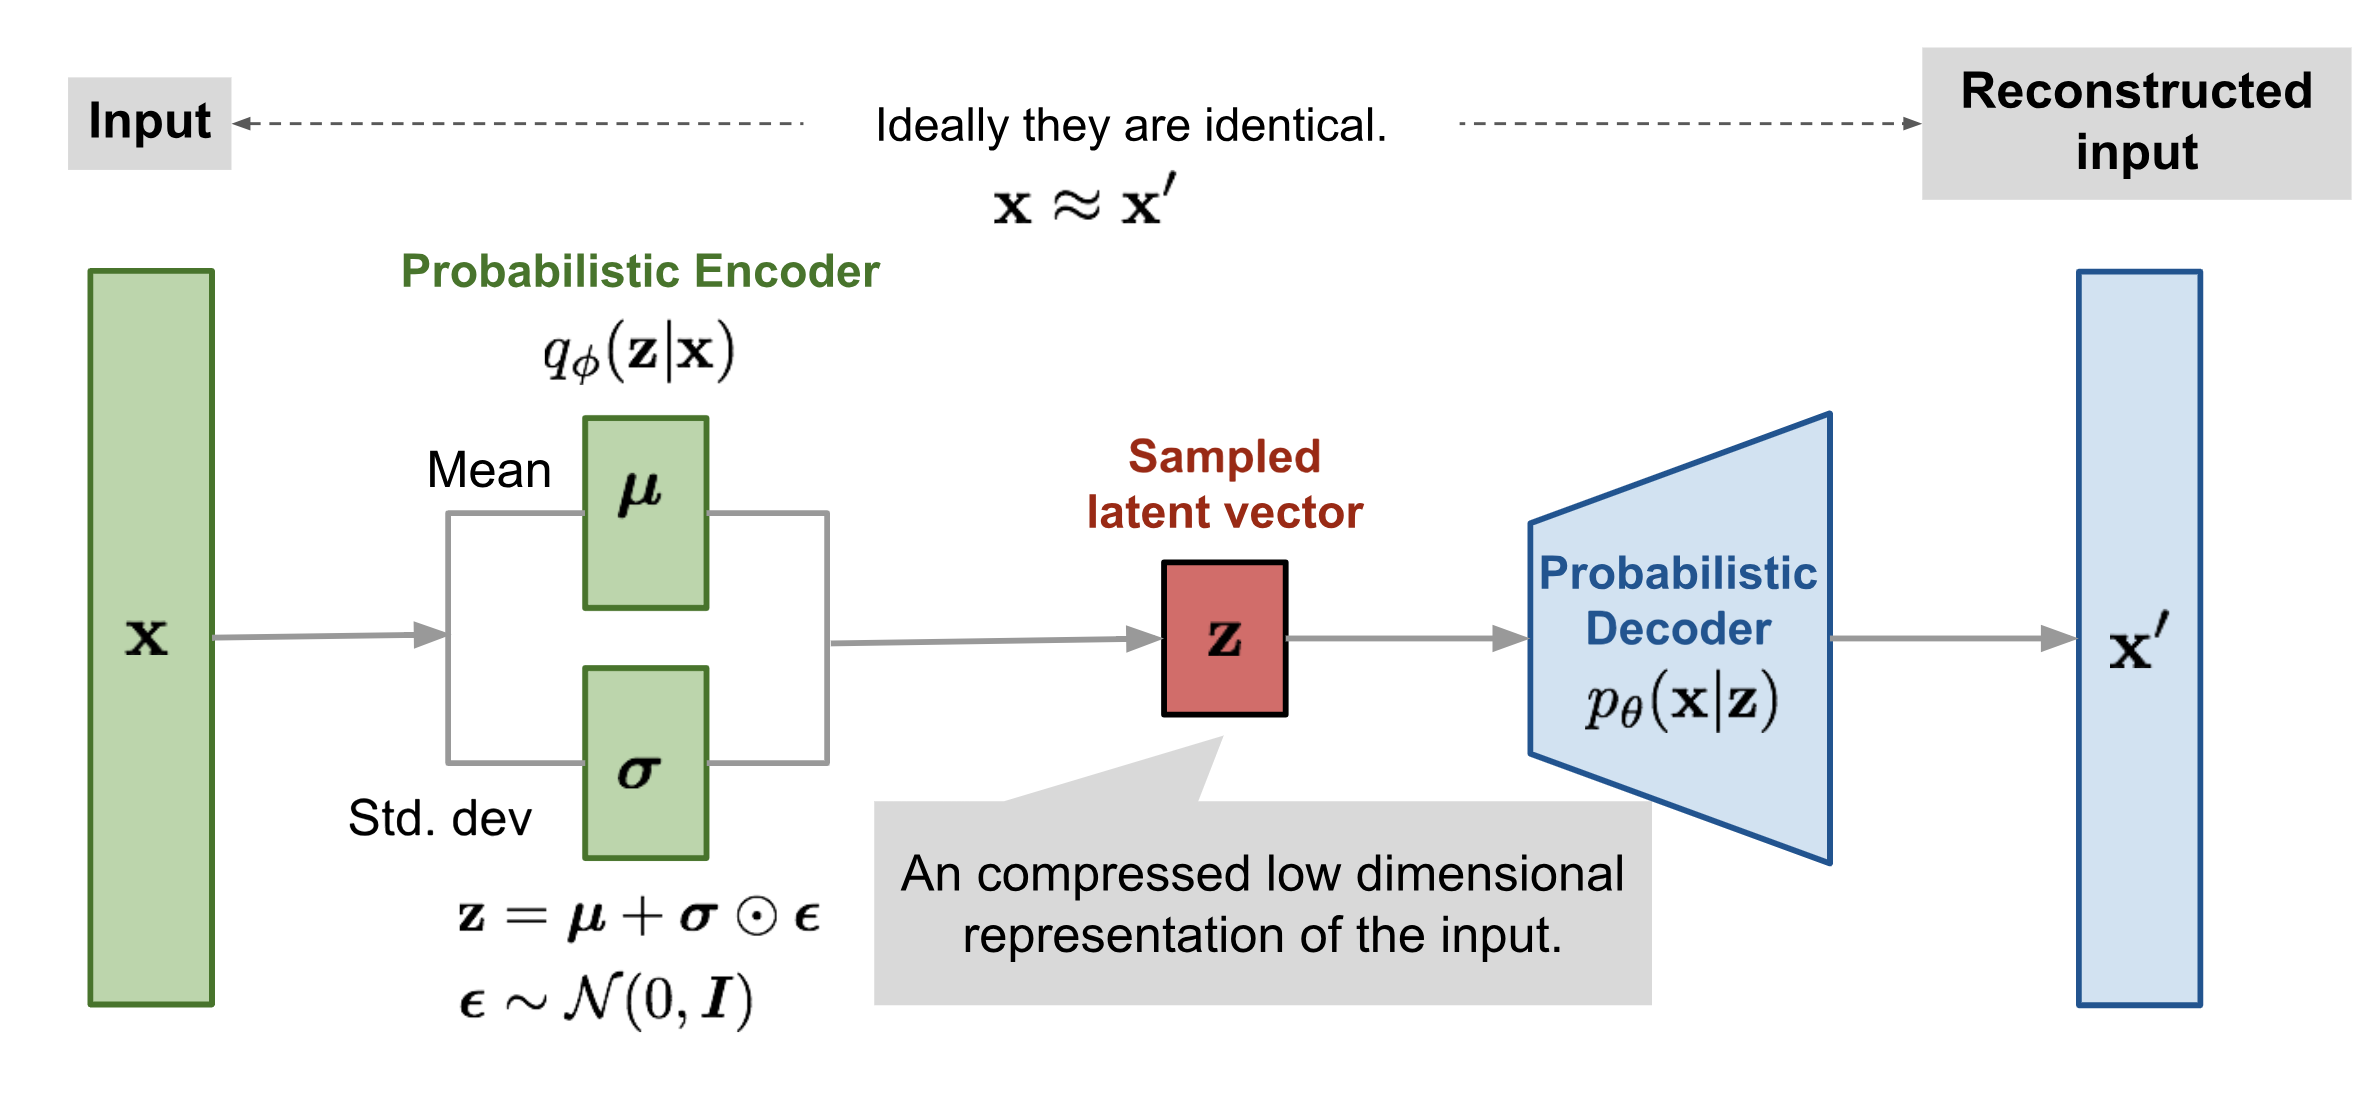

$x_1, \dots x_n$ is samples from unknown distribution $p(x)$

$$L(q, \theta) = \mathbb{E}_{z_1, \dots z_N \sim q(\boldsymbol{z}| \boldsymbol{x}, \phi)} \ln p(x_1, \dots x_N|\boldsymbol{z}, \theta) - KL(q(z_1, \dots, z_N| \boldsymbol{x}, \phi)||p(z_1, \dots , z_N))$$

In the questions below consider 2 cases:

* $2D$ data
* Images data

**Question 1.** How to model VAE encoder $q(\boldsymbol{z} | \boldsymbol{x}, \phi)$? What does the encoder take as **input**? What is the **output** of the encoder?

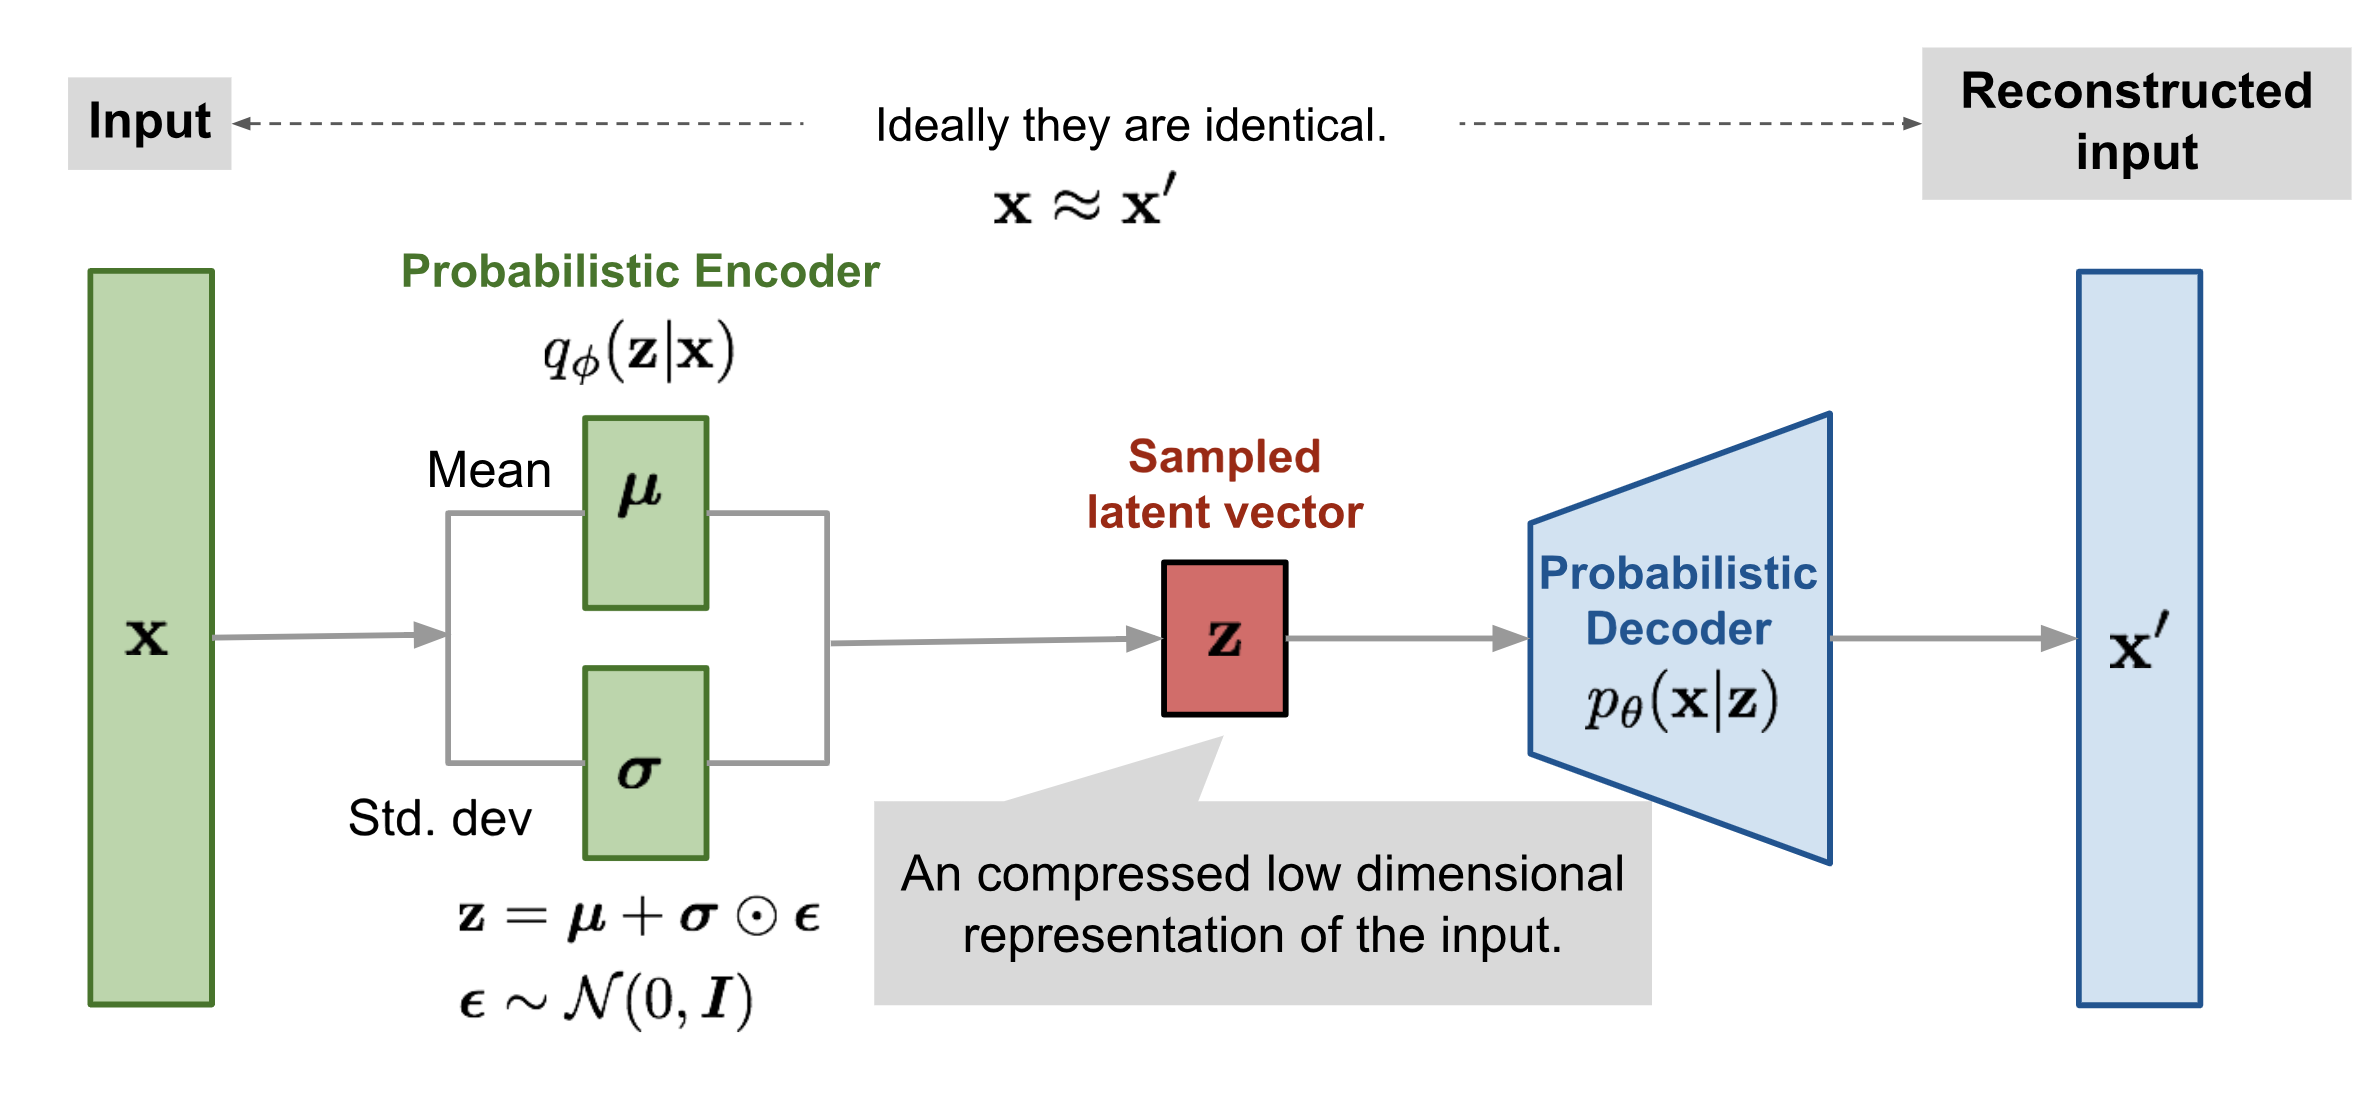

```python
# x : tensor (bs, 2) - first case
#   : tensor (bs, 3, w, h) - second case

z_stats = VAEEncoder(x) # (bs, 2*z_dim)

mu_z = z_stats[:, :z_dim] #(bs, z_dim)
log_sigma_z = z_stats[:, z_dim:] # (bs, z_dim)
```

**Question 2.** How to model VAE decoder $p(\boldsymbol{x} | \boldsymbol{z}, \theta)$? What does the decoder take as **input**? What is the **output** of the decoder?

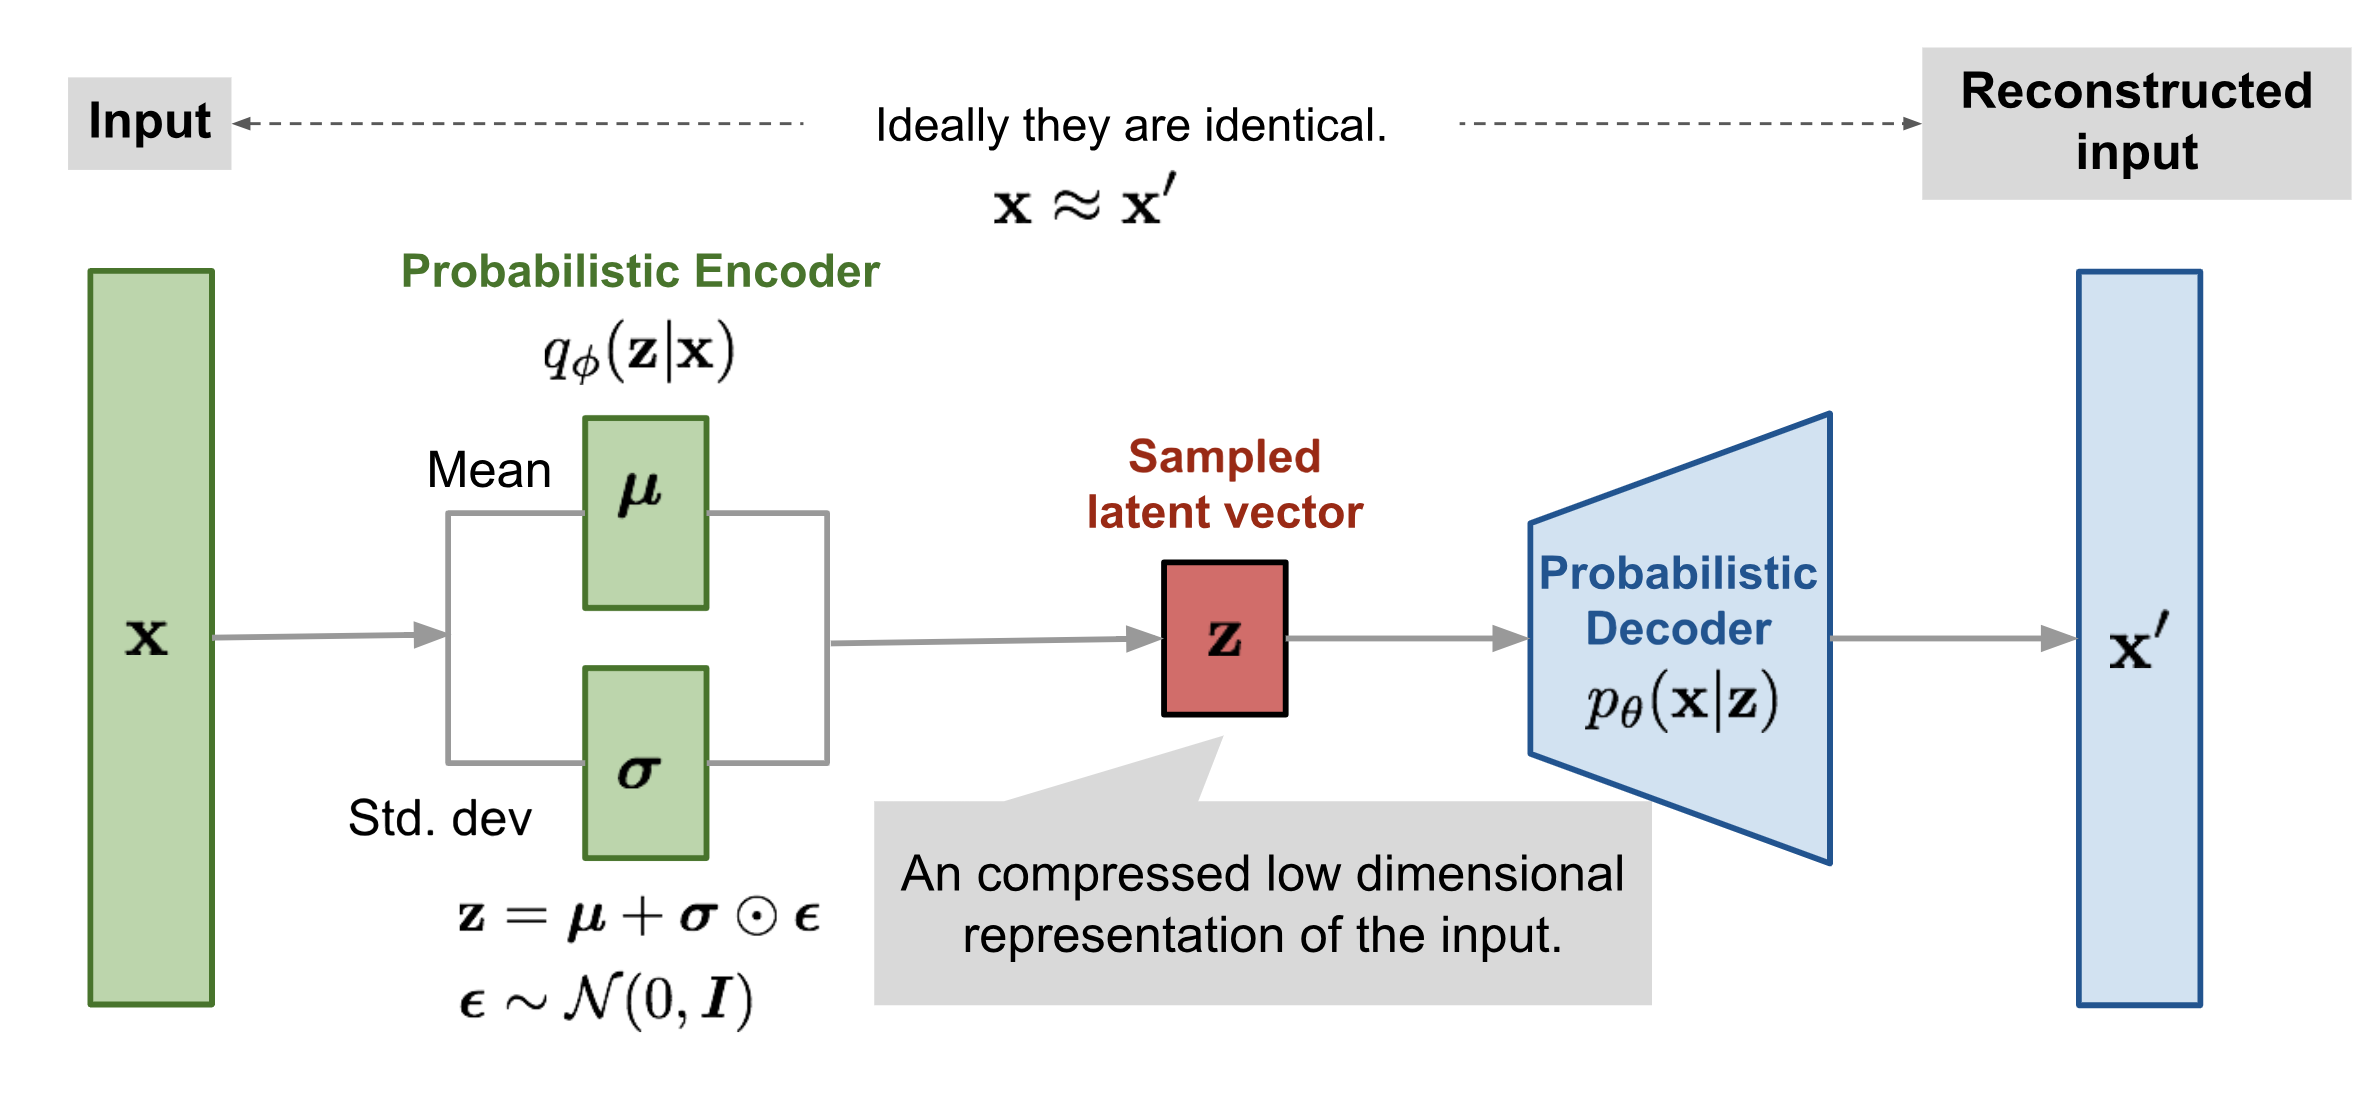

```python
# z : tensor (bs, z_dim)

X_stats = VAEDecoder(z) # X : tensor (bs, 2 * 2) - first case (mu, log_sigma)
                        #   : tensor (bs, 3, w, h ) - second case (predict only mu's / probability of 1!)
...

if not sample_from_decoder:
    return \mu_X
else:
    return sample N(\mu_X, \sigma_X)
```

**Question 3.** How to model $p(z)$?

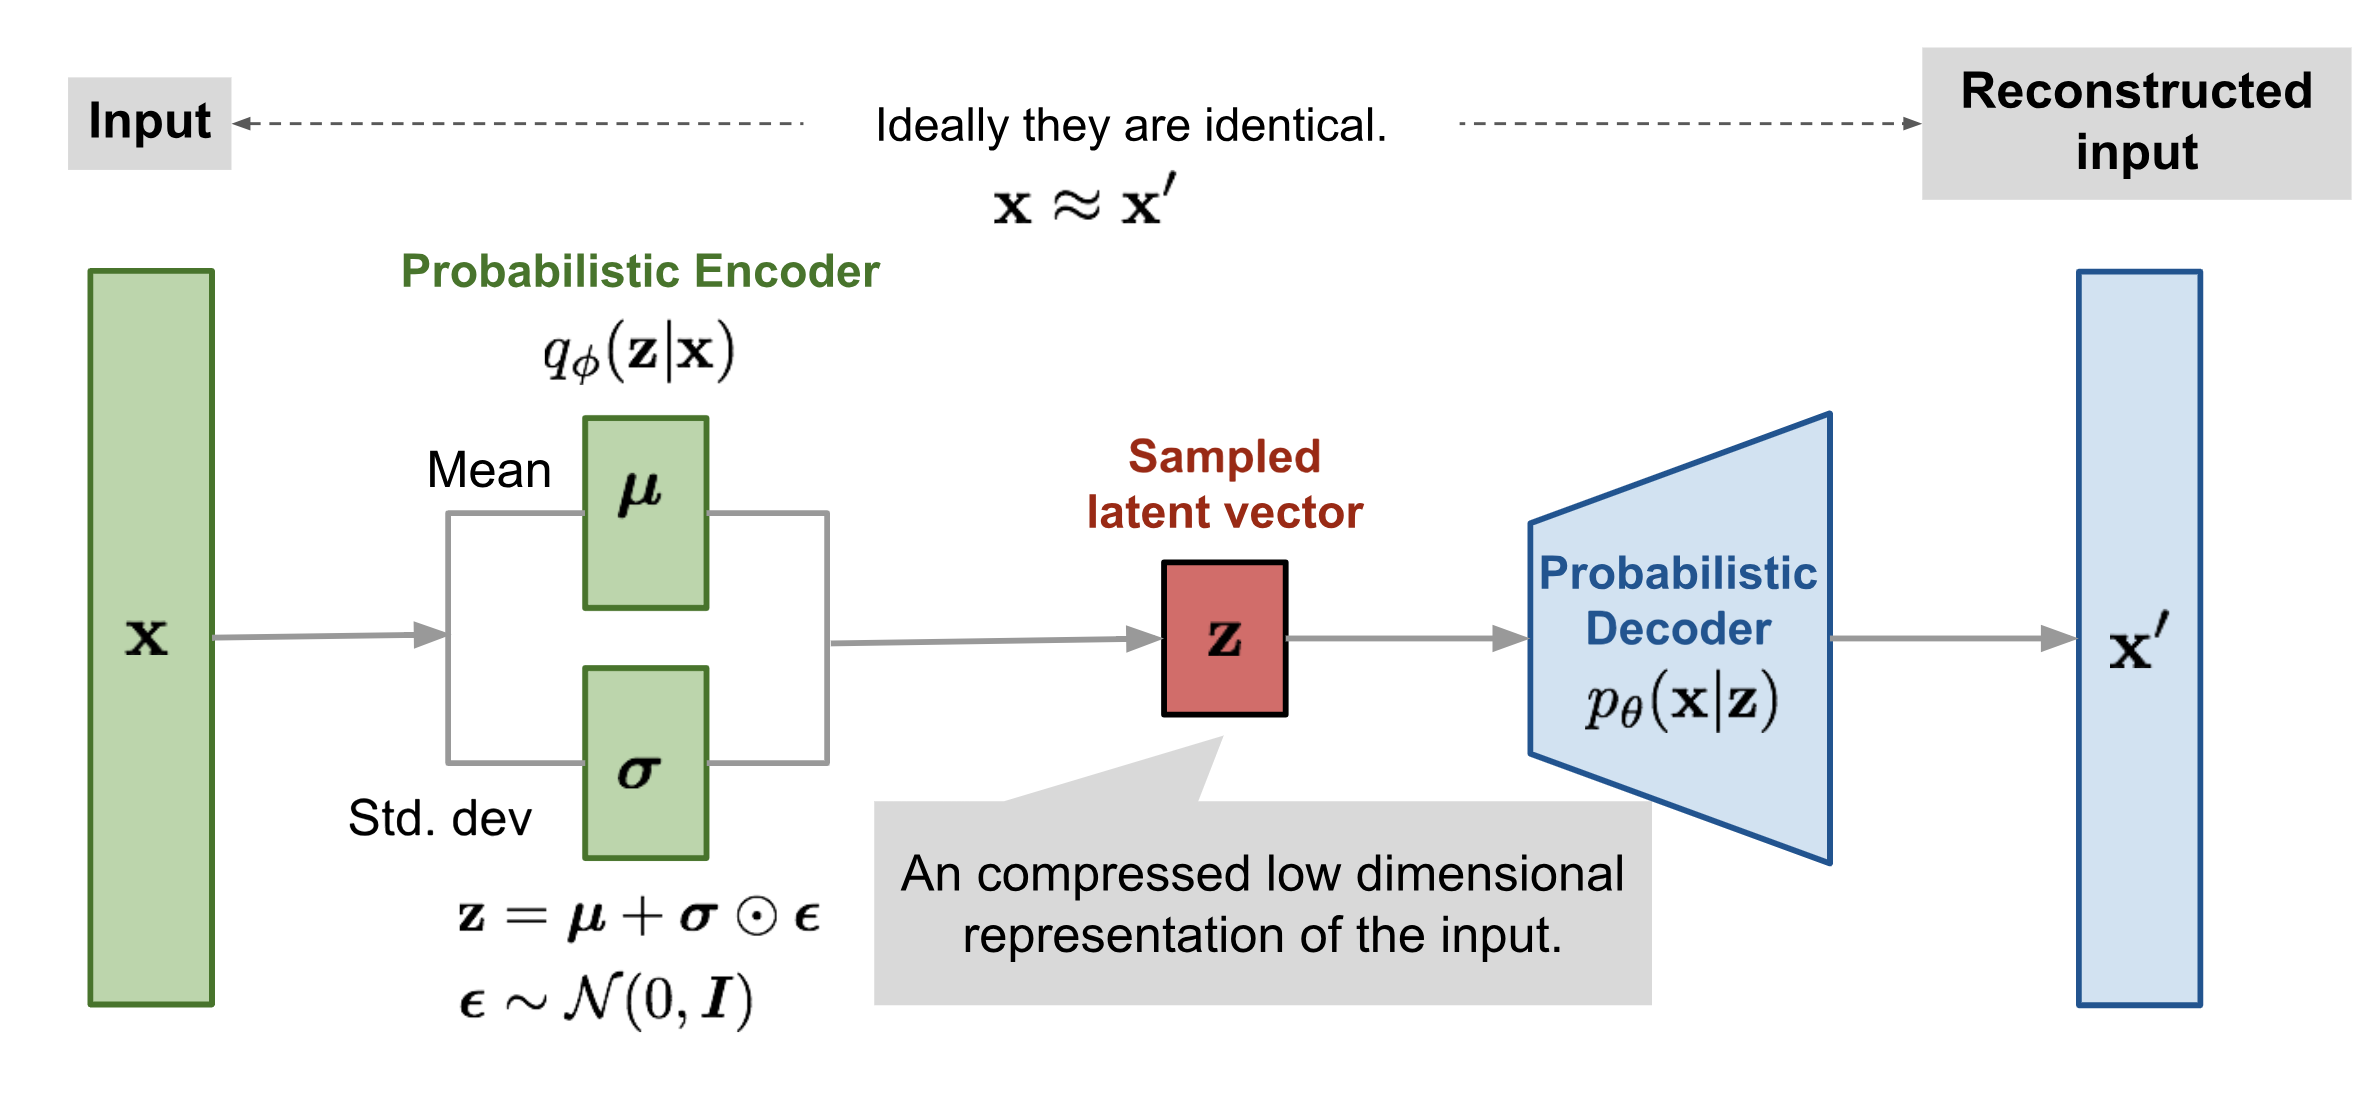

$\mathcal{N}(0, I_{\text{z_dim}})$

**Question 4.** How to sample from VAE?

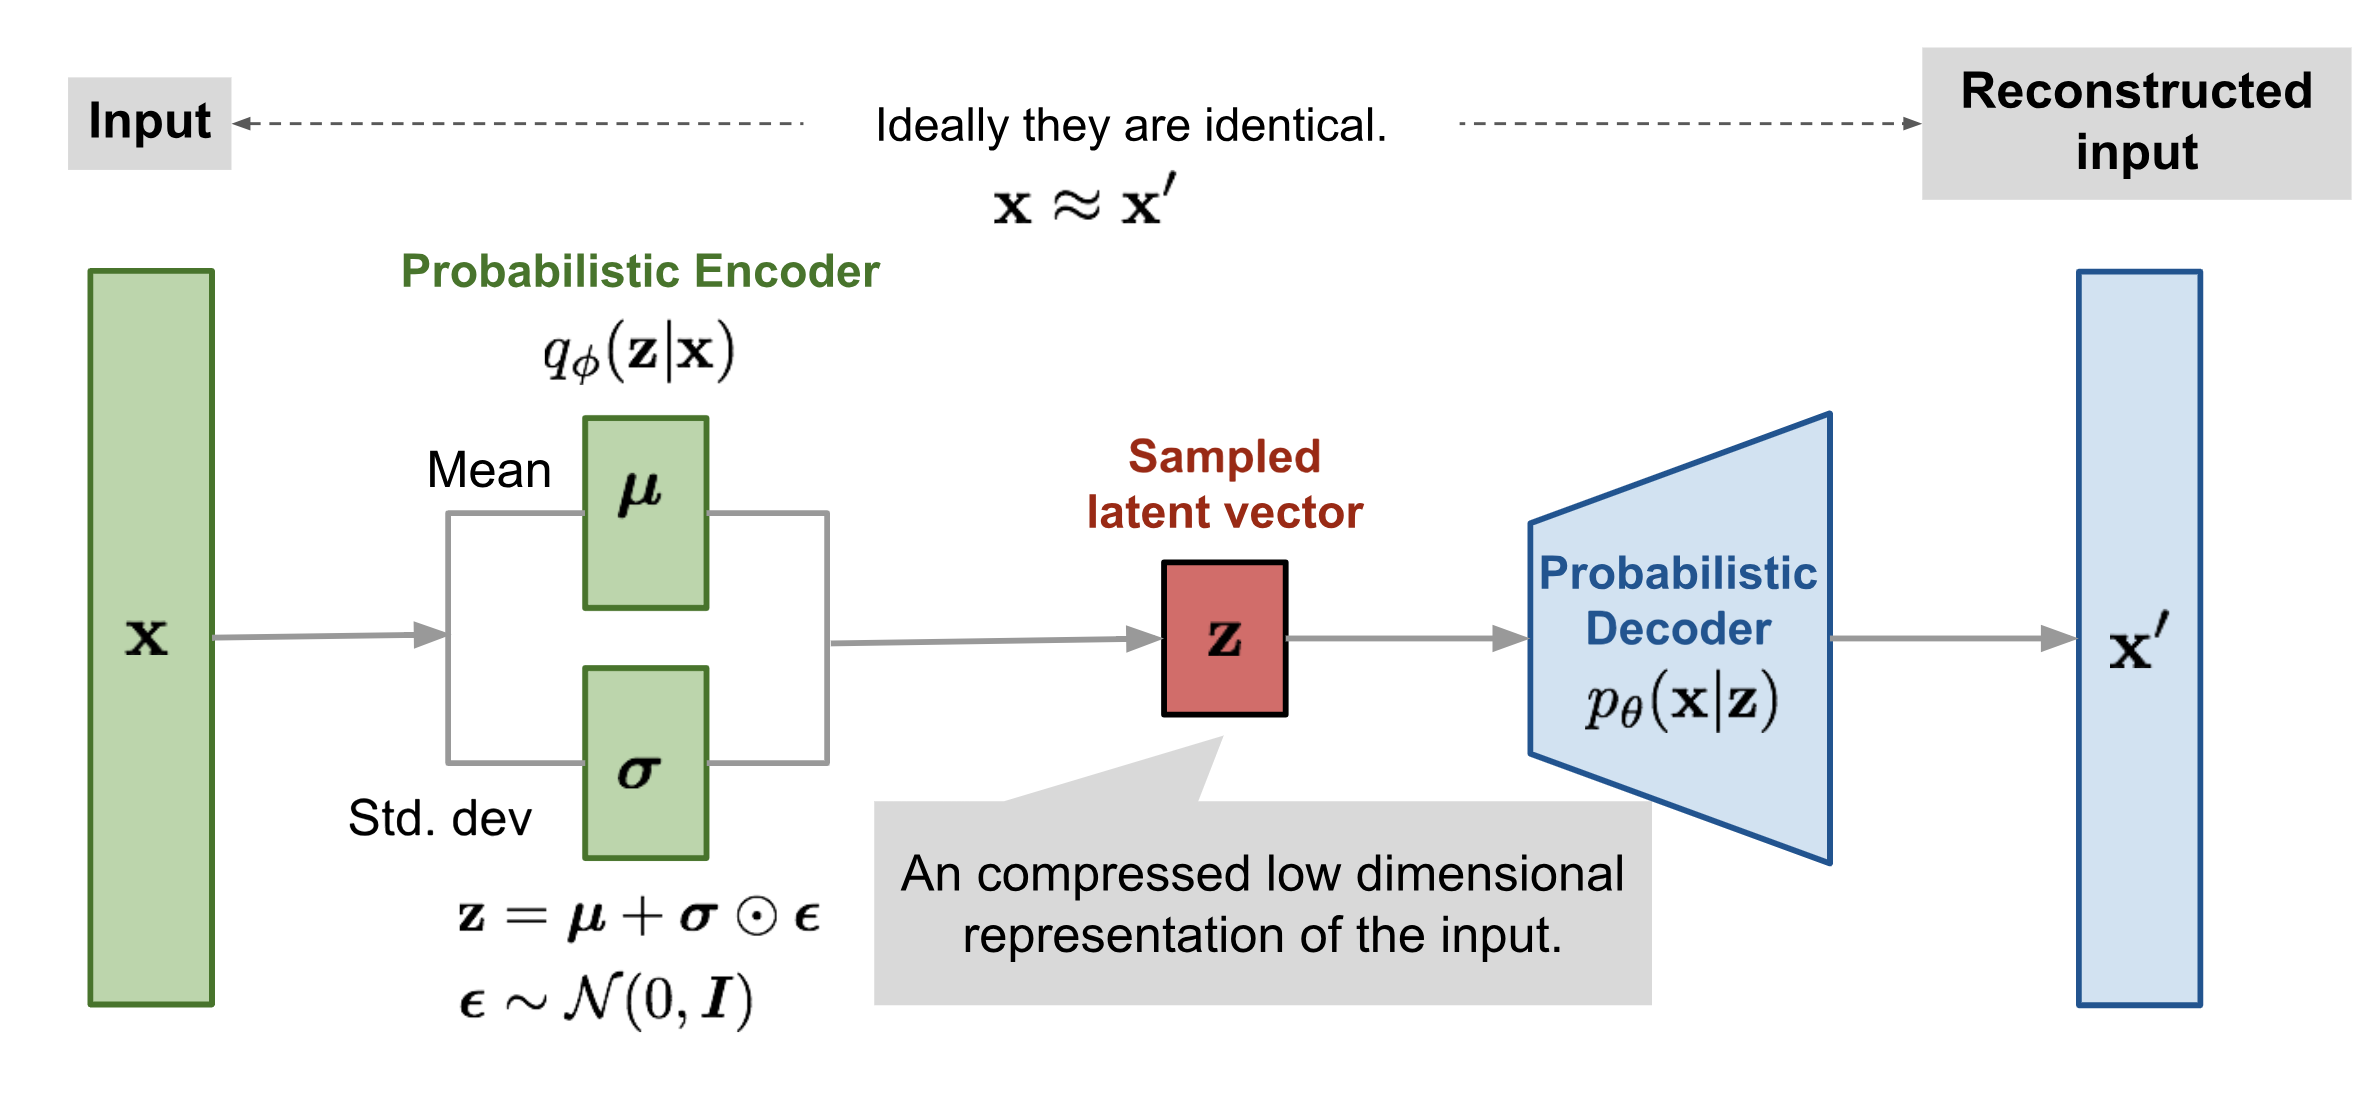

```python
1. z_sample = samples N(0, I_{z_dim}) of shape (bs,) # tensor (bs, z_dim)

2. X_stats = VAEDecoder(z_sample) # X : tensor (bs, 2 * 2) - first case
                                  #   : tensor (bs, 3, w, h ) - second case (predict only mu's!)
...
```

**Question 5.** 

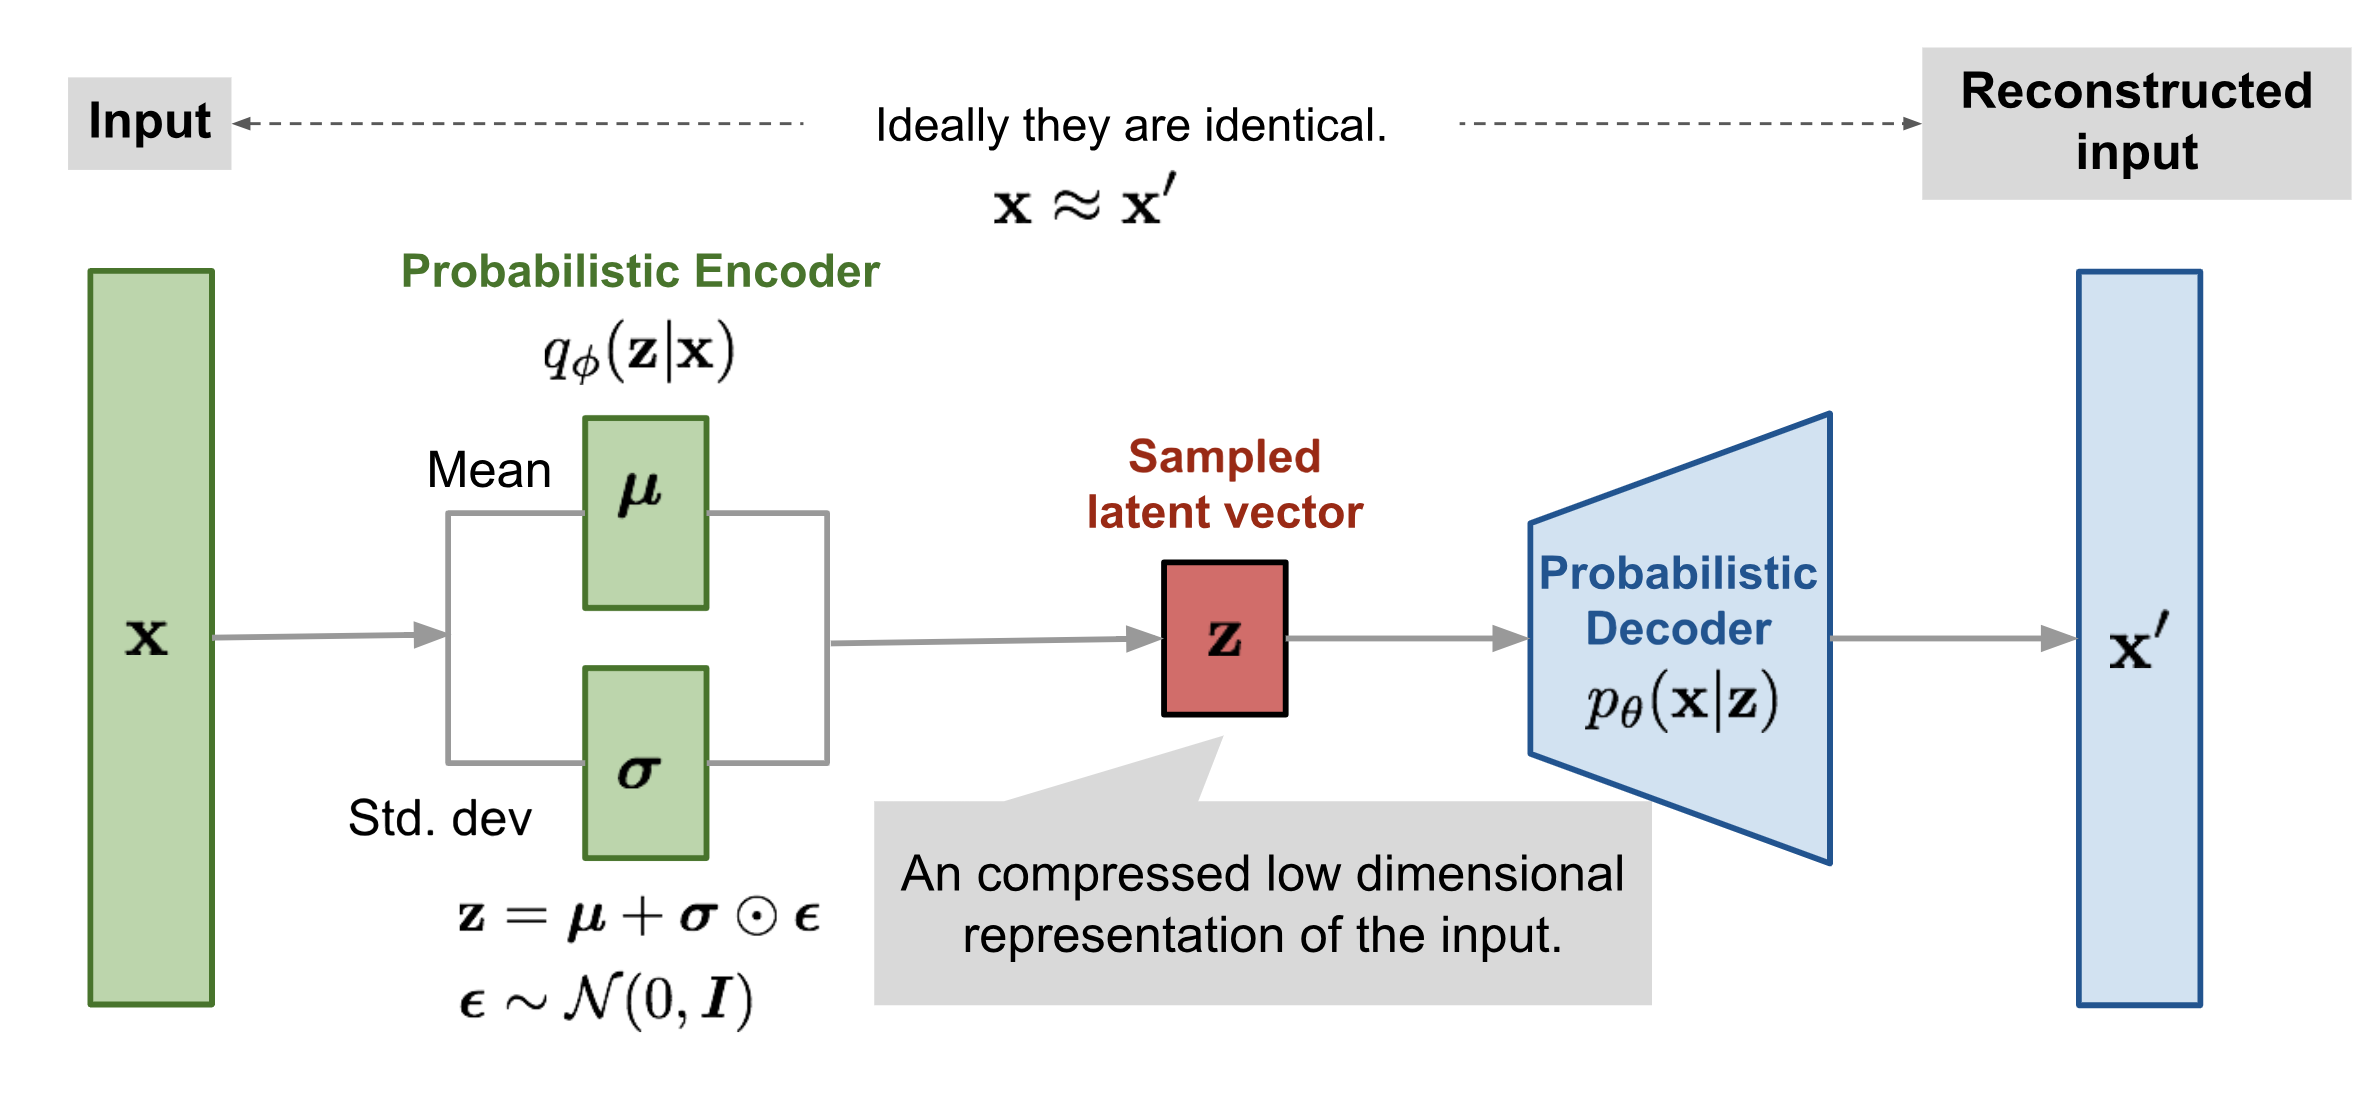

1. Which **loss** function are we optimizing? How do we optimize it?

2. What parameters do we optimize?

3. How does it relate to the EM algorithm?

```python
for x in dataloader:
    vae_opt.zero_grad()
    loss = vae_loss(x) # what is the loss function here???
    loss.backward()
    vae_opt.step()
```

We have samples $x_1, \dots x_N$ from unknown distribution $p(x)$.

1. Our optimal goal is to maximize **ELBO**:

    $$L(\phi, \theta) = \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) - KL(q(z_n| x_n, \phi)||p(z_n))\right)$$
    
   but we do it in a tricky way:
   
   * $p(z_n) = \mathcal{N}(0, I_{\text{z_dim}})$
   
   * $q(z_n| x_n, \phi) = \mathcal{N}\big{(}\mu_z(x_n|\phi), \text{diag}\left( \sigma^{(1)}_z(x_n| \phi), \dots \sigma^{(\text{z_dim})}_z(x_n | \phi)\right)\big{)}$
   
   * $\Rightarrow$ $KL(q(z_n| x_n, \phi)||p(z_n))$ has closed-form expression (as a function of $\mu_z(x_n|\phi), \boldsymbol{\sigma_z}(x_n | \phi)$)
   
   * $p(x_n | z_n, \theta) = $
       
       * $\mathcal{N}\big{(}\mu_x(z_n|\theta), \text{diag}\left( \sigma^{(1)}_x(z_n| \theta), \dots \sigma^{(\text{x_dim})}_x(z_n | \theta)\right)\big{)}$, <span style="color:red"> or </span>
       
       * $\mathcal{N}\big{(}\mu_x(z_n|\theta), I_{\text{x_dim}}\big{)}$
   
   * One-sample estimate of $\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta)$ : 
   
   $$\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) = \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I_{\text{z_dim}})} \ln p\big{(}x_n \big{|}\mu_z(x_n | \phi) + \boldsymbol{\sigma}_z(x_n | \phi) \odot \epsilon, \theta \big{)} \approx\\ \approx \ln p\big{(} x_n \big{|} \mu_z(x_n | \phi) + \boldsymbol{\sigma}_z(x_n | \phi) \odot \epsilon_n, \theta\big{)}\, , \, \epsilon_n \sim \mathcal{N}(0, I_{\text{z_dim}})$$
   
    **Subquestion 5.1**: How to compute the log-likelihood $\ln p(x_n | z_n, \theta)$?
    
   <span style="color:red"> Final **ELBO** objective (`vae_loss`) </span>: We substitute **ELBO** objective with stochastic estimate of **ELBO** objective scaled by $\frac{\text{batch_size}}{N}$:
   
   $$
   \text{vae_loss} = \frac{1}{\text{batch_size}} \sum\limits_{i = 1}^{\text{batch_size}} \Big{(} - \ln p\big{(} x_{b[i]} \big{|} \mu_z(x_{b[i]} | \phi) + \boldsymbol{\sigma}_z(x_{b[i]} | \phi) \odot \epsilon_i, \theta\big{)} + KL(q(z_{b[i]}| x_{b[i]}, \phi)||p(z_{b[i]}))\Big{)} \approx - \frac{1}{N} L(\phi, \theta)
   $$
 
 
2. We optimize ELBO with respect to both $\phi$ (decoder parameters) and $\theta$ (encoder parameters) 

3. The optimization procedure is actually **Variational EM** algorithm in a joint manner:

$$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}} \\
\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} L(q(\cdot| \boldsymbol{X}, \color{red}{\phi_{k}}), \theta)|_{\theta=\theta_{k}}$$

### 2D VAE implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

import pickle
import os
import sys

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
    USE_CUDA = True
else:
    DEVICE='cpu'
    USE_CUDA = False

from typing import Optional, Tuple
from tqdm.notebook import tqdm

Loading `dgm_utils` for colab users

In [ ]:
REPO_NAME = "2024-DGM-Summer-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

Loading `dgm_utils` from local

In [2]:
import os, sys
DGM_UTILS_PATH = '../../homeworks'
sys.path.append(DGM_UTILS_PATH)

In [3]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import visualize_2d_data, visualize_2d_samples
from dgm_utils import show_samples, visualize_images, load_dataset

In what follows we will implement simple VAE model for 2d gaussian distribution $\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$.

We will consider two cases: 
* 2d univariate distribution (diagonal covariance matrix $\boldsymbol{\Sigma}$);
* 2d multivariate distribution (strictly non-diagonal covariance matrix $\boldsymbol{\Sigma}$).

The goal is to analyze the difference between these two cases and understand why the trained VAE models will behave differently.

Below you will find data generation function. Look carefully, do not change.

In [4]:
def generate_2d_data(
    count: int, mode: str = "univariate"
) -> Tuple[np.ndarray, np.ndarray]:
    assert mode in ["univariate", "multivariate"]
    np.random.seed(42)
    mean = [[2.0, 3.0]]
    sigma = [[3.0, 1.0]]
    if mode == "univariate":
        rotate = [[1.0, 0.0], [0.0, 1.0]]
    else:
        rotate = [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]]
    data = mean + (np.random.randn(count, 2) * sigma).dot(rotate)
    data = data.astype("float32")
    split = int(0.7 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

Let generate the data and visualize it. We will generate data for two cases.

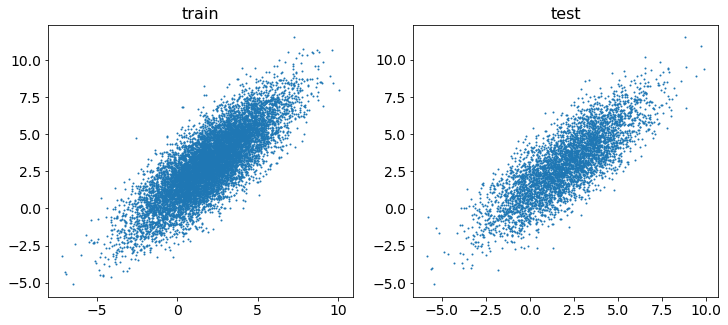

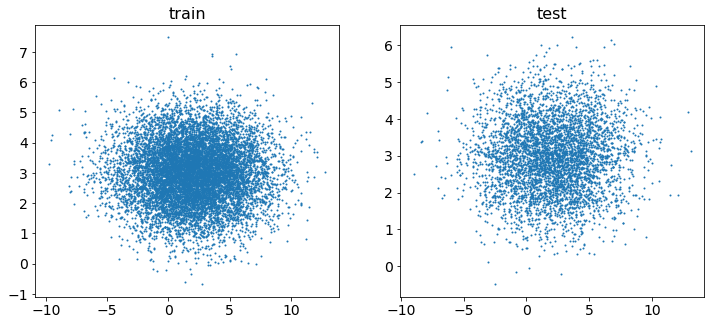

In [5]:
COUNT = 15000

train_data, test_data = generate_2d_data(COUNT, mode="multivariate")
visualize_2d_data(train_data, test_data)

train_data, test_data = generate_2d_data(COUNT, mode="univariate")
visualize_2d_data(train_data, test_data)

The difference of these two cases is the form of covariance matrix $\boldsymbol{\Sigma}$.

In multivariate case the matrix is non-diagonal, in univariate case it is strictly diagonal. As you will see, our VAE model will have absolutely different results for these datasets.

Now it is time to define our model. Our model will have the following structure:

* The latent dimensionality is equal to 2, the same as the data dimensionality ($\mathbf{z} \in \mathbb{R}^2$, $\mathbf{x} \in \mathbb{R}^2$).
* Prior distribution is standard Normal ($p(\mathbf{z}) = \mathcal{N}(0, I)$).
* Variational posterior distribution (or encoder) is $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$. Here $\boldsymbol{\phi}$ denotes all parameters of the encoder neural network. 
* Generative distribution (or decoder) is $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$. Here $\boldsymbol{\theta}$ denotes all parameters of the decoder neural network. Please note, that here we will use continuous distribution for our variables $\mathbf{x}$.
* We will consider only diagonal covariance matrices $\boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x})$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$.

Model objective is ELBO:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$

To make the expectation is independent of parameters $\boldsymbol{\phi}$, we will use reparametrization trick.

To calculate the loss, we should derive
- $\log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$, note that generative distribution is $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$.
- KL between $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$ and $\mathcal{N}(0, I)$.

Let start with the helper functions.

In [6]:
def get_normal_KL(
    mean_1: torch.Tensor,
    log_std_1: torch.Tensor,
    mean_2: Optional[torch.Tensor] = None,
    log_std_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    :Parameters:
    mean_1: means of normal distributions (1)
    log_std_1 : standard deviations of normal distributions (1)
    mean_2: means of normal distributions (2)
    log_std_2 : standard deviations of normal distributions (2)
    :Outputs:
    kl divergence of the normal distributions (1) and normal distributions (2)
    ---
    This function should return the value of KL(p1 || p2),
    where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
    If mean_2 and log_std_2 are None values, we will use standard normal distribution.
    Note that we consider the case of diagonal covariance matrix.
    """

    pass


def get_normal_nll(
    x: torch.Tensor, mean: torch.Tensor, log_std: torch.Tensor
) -> torch.Tensor:
    """
    This function should return the negative log likelihood log p(x),
    where p(x) = Normal(x | mean, exp(log_std) ** 2).
    Note that we consider the case of diagonal covariance matrix.
    """
    
    pass

In [10]:
from seminar6_utils import get_normal_KL, get_normal_nll

In [11]:
def test_KL():
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)
        ).numpy(),
        200.2144,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)
        ).numpy(),
        1.50925,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_KL(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        [49.2990, 1498.479],
        rtol=1e-3,
    )


test_KL()

In [12]:
def test_NLL():
    assert np.isclose(
        get_normal_nll(torch.tensor(2), torch.tensor(2), torch.tensor(3)).numpy(),
        3.9189,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_nll(torch.tensor(5), torch.tensor(-3), torch.tensor(6)).numpy(),
        6.9191,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_nll(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        np.array([3.9982, 5.9197]),
        rtol=1e-3,
    )


test_NLL()

We will use simple fully connected dense networks for encoder and decoder.

In [13]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape: int, hiddens: list, output_shape: int) -> None:
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model = []

        # ====
        # your code 
        # stack Dense layers with ReLU activation
        # note: you do not have to add relu after the last dense layer
        prev_h = input_shape
        for h in hiddens:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.append(nn.Linear(hiddens[-1], output_shape))
        # ====
        self.net = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) ->  torch.Tensor:
        # ====
        # your code
        # apply network that was defined in __init__ and return the output
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, *self.output_shape)
        # ====

Now it is time to implement the VAE model.

In [14]:
class VAE2d(nn.Module):
    def __init__(
        self, n_in: int, n_latent: int, enc_hidden_sizes: list, dec_hidden_sizes: list
    ) -> None:
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent

        # ====
        # your code
        # define encoder and decoder networks
        # the encoder takes n_in elements, has enc_hidden_sizes neurons in hidden layers
        # and outputs 2 * n_latent (n_latent for means, and n_latent for std)
        # the decoder takes n_latent elements, has dec_hidden_sizes neurons in hidden layers
        # and outputs 2 * n_in (n_in for means, and n_in for std)
        self.encoder = FullyConnectedMLP(n_in, enc_hidden_sizes, 2 * n_latent)
        self.decoder = FullyConnectedMLP(n_latent, dec_hidden_sizes, 2 * n_in)
        # ====

    def prior(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # return n samples from prior distribution (we use standard normal for prior)
        samples = torch.randn(n, self.n_latent)
        if USE_CUDA:
            samples = samples.cuda()
        return samples
        # ====

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # now you have to return from the model
        # - mu_z - means for variational distribution
        # - mu_x - means for generative distribution
        # - log_std_z - logarithm of std for variational distribution
        # - log_std_x - logarithm of std for generative distribution
        # we use logarithm, since the std is always positive
        # to get std we will exponentiate it to get rid of this constraint

        # 1) mu_z, log_std_z are outputs from the encoder
        # 2) apply reparametrization trick to get z (input of decoder)
        # (do not forget to use self.prior())
        # 3) mu_x, log_std_x are outputs from the decoder
        #    Note: [mu, log_std = decoder(input).chunk(2, dim=1)]

        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = self.prior(mu_z.shape[0]) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)
        # ====
        return mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x: torch.Tensor) -> dict:
        mu_z, log_std_z, mu_x, log_std_x = self(x)
        # ====
        # your code
        # 1) apply model to get mu_z, log_std_z, mu_x, log_std_x
        # 2) compute reconstruction loss using get_normal_nll (it is the first term in ELBO)
        # 3) compute KL loss using get_normal_KL (it is the second term in ELBO)
        recon_loss = get_normal_nll(x, mu_x, log_std_x)
        recon_loss = recon_loss.sum(1).mean()

        kl_loss = get_normal_KL(mu_z, log_std_z)
        kl_loss = kl_loss.sum(1).mean()
        # ====

        return {
            "elbo_loss": recon_loss + kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int, sample_from_decoder: bool = True) -> np.ndarray:
        with torch.no_grad():
            # ====
            # your code
            # to sample from VAE model you have to sample from prior
            # and then apply decoder to prior samples.
            # parameter noise indicates whether to sample from decoder
            # or just use means of generative distribution as samples
            # 1) generate prior samples
            # 2) apply decoder
            # 3) sample from the decoder distribution if sample_from_decoder=True
            z = self.prior(n)
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if sample_from_decoder:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
            # ====
        return z.cpu().numpy()

We will use the following function for training our models. Look carefully, do not change.

In [15]:
def solve_task(
    train_data: np.ndarray,
    test_data,
    model: np.ndarray,
    batch_size: int,
    epochs: int,
    lr: float,
    use_cuda: bool = False,
    use_tqdm: bool = False,
) -> None:
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model,
        train_loader,
        test_loader,
        epochs=EPOCHS,
        lr=LR,
        use_cuda=use_cuda,
        use_tqdm=use_tqdm,
        loss_key="elbo_loss",
    )
    samples_noise = model.sample(3000, sample_from_decoder=True)
    samples_nonoise = model.sample(3000, sample_from_decoder=False)

    for key, value in test_losses.items():
        print("{}: {:.4f}".format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)
    visualize_2d_samples(samples_noise, title="Samples with Decoder Noise")
    visualize_2d_samples(samples_nonoise, title="Samples without Decoder Noise")

In [16]:
# ====
# your code
# choose these parameters (2 hidden layers could be enough for encoder and decoder)
ENC_HIDDEN_SIZES = [128, 128]
DEC_HIDDEN_SIZES = [128, 128]
BATCH_SIZE = 128  # any adequate value
EPOCHS = 10  # < 10
LR = 0.001  # < 1e-2
# ====

COUNT = 10000

Firstly, we will train the VAE model for multivariate gaussian distribution.

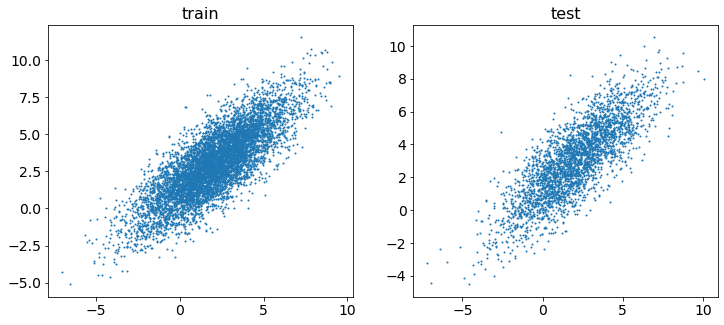

elbo_loss: 3.9602
recon_loss: 2.8456
kl_loss: 1.1146


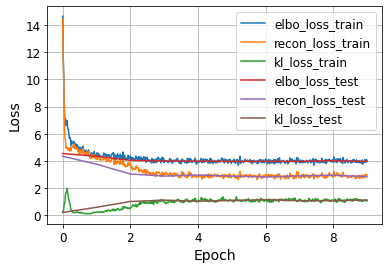

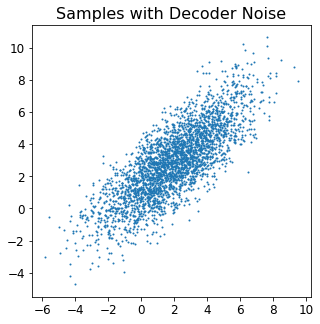

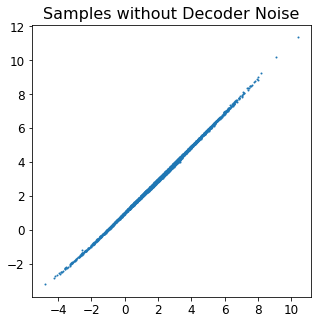

In [17]:
train_data, test_data = generate_2d_data(COUNT, mode="multivariate")
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES)
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=USE_CUDA)

In [18]:
# add bin mnist code

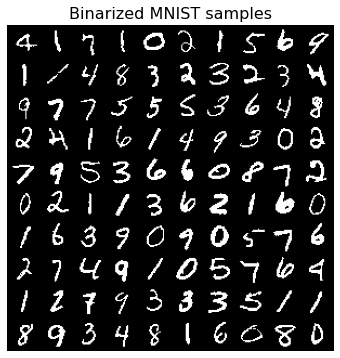

In [19]:
train_data, train_labels, test_data, test_labels = load_dataset("mnist", flatten=False, binarize=True, with_targets=True)
visualize_images(train_data, "Binarized MNIST samples")

In [20]:
class VAE_bin_image(VAE2d):
    def __init__(
        self, n_in: int, n_latent: int, enc_hidden_sizes: list, dec_hidden_sizes: list
    ) -> None:
        super().__init__(n_in=n_in, n_latent=n_latent,
                         enc_hidden_sizes=enc_hidden_sizes, dec_hidden_sizes=dec_hidden_sizes)
        self.decoder = FullyConnectedMLP(n_latent, dec_hidden_sizes, n_in)

    
    def forward(self, x: torch.Tensor) -> tuple:
        orig_shape = x.shape
        x = x.view(x.shape[0], -1)
        
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = self.prior(mu_z.shape[0]) * log_std_z.exp() + mu_z
        logits = self.decoder(z)
        logits = logits.view(*orig_shape)
        return mu_z, log_std_z, torch.sigmoid(logits)
    
    def loss(self, x: torch.Tensor) -> dict:
        mu_z, log_std_z, recon_x = self(x)
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.shape[0]

        kl_loss = get_normal_KL(mu_z, log_std_z)
        kl_loss = kl_loss.sum(1).mean()
        

        return {
            'elbo_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    
    def get_latent(self, x):
        with torch.no_grad():
            x = torch.from_numpy(x).float()
            x = x.view(x.shape[0], -1)
            mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        
        return mu_z, log_std_z.exp()
        
    def sample(self, n):
        with torch.no_grad():
            z = self.prior(n)
            recon_x = torch.sigmoid(self.decoder(z).view((n, 1, 28, 28)))
            
        return recon_x.cpu().numpy()

In [21]:
ENC_HIDDEN_SIZES = [128, 64, 32]
DEC_HIDDEN_SIZES = [32, 64, 128]
BATCH_SIZE = 128
EPOCHS = 20
LR = 0.003

In [22]:
model = VAE_bin_image(28*28, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).float()

elbo_loss: 139.4231
recon_loss: 132.8047
kl_loss: 6.6185


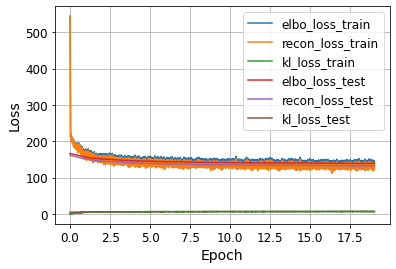

In [23]:
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))

plot_training_curves(train_losses, test_losses)

In [24]:
show_samples(samples, "VAE samples")

NameError: name 'samples' is not defined

In [ ]:
def get_batch_of_labels(label, batch_size, data_with_labels=(test_data, test_labels)):
    data, labels = data_with_labels
    idx = np.random.choice(np.argwhere(labels == label).flatten(), batch_size, replace=False)
    
    return data[idx]

In [ ]:
batch = get_batch_of_labels(0, 100)

In [ ]:
show_samples(batch, None)

In [ ]:
from scipy.stats import multivariate_normal

def get_pdf(mu, sigma):
    mu = np.array(mu)
    sigma = np.array(sigma)
    
    x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mu, [[sigma[0], 0],[0, sigma[1]]])
    return rv.pdf(pos)

def get_pic(mu, sigma):
    res = get_pdf(mu, sigma)
    pic = res.T[::-1,:]
    
    return pic[None, ...]

def get_pics(mu_s, sigma_s):
    return np.array([get_pic(m, s) for m,s in zip(mu_s, sigma_s)])

In [ ]:
prior = get_pic(np.array([0,5]), np.array([1,1]))

In [ ]:
prior.shape

In [ ]:
figsize = (10,10)
nrow = 10

for i in range(10):
    batch = get_batch_of_labels(i, 100)
    show_samples(batch, f'batch of {i}', nrow=nrow, figsize=figsize)

    latent_batch = model.get_latent(batch)
    latent_pics = get_pics(*latent_batch)
    show_samples(latent_pics, 'latent_batch', nrow=nrow, figsize=figsize)
    
    res = latent_pics.mean(axis=0)[0]
    plt.figure(figsize=figsize)
    plt.imshow(res)
    #plt.xlim(-5,5)
    #plt.ylim(-5,5)

In [ ]:
a = 3
step = 0.25

x, y = np.mgrid[a:-a:-step, -a:a:step]
pos = np.dstack((y, x))
n_row = pos.shape[0]

pos = pos.reshape((np.product(pos.shape[:2]), 2))

samples = torch.sigmoid(model.decoder(torch.from_numpy(pos).float()))
samples = samples.detach().numpy().reshape((samples.shape[0], 1, 28, 28))

In [ ]:
show_samples(samples, 'latent grid', figsize=figsize)